# Article Recommendation

TODO
- [ ] wordcloud
- [ ] graphs, charts, statistics


In [116]:
import numpy as np
import bs4
import requests
import pandas as pd
import re
import fandom
import random
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# flags 
LOAD = True
SAVE = False

## Scrapping

In [3]:
domain_address = 'https://rickandmorty.fandom.com/'
all_pages_subpage = '/wiki/Special:AllPages'

### Scrapping the links of all subpages in a fandom

We need to scrape all the reference links from all the hub pages in a given fandom.

In [5]:
if not LOAD:

    next_page_link = domain_address + all_pages_subpage
    list_of_pages = []

    # collect all links
    count = 0

    re_next = re.compile(r'Next page')

    while count < 50:
        time.sleep(random.randrange(3, 7)*0.1)
        response = requests.get(next_page_link)
        parsed = bs4.BeautifulSoup(response.text)

        div_with_list_of_links = parsed.find_all('div', {'class':'mw-allpages-body'})[0]

        for a_element in div_with_list_of_links.find_all('a', href=True):
            list_of_pages.append(domain_address + a_element['href'])
        
        next_page_div = parsed.find_all('div', {'class':'mw-allpages-nav'})[0]
        page_routes = next_page_div.find_all('a', href=True)
        next_page_route = None
        for page_route in page_routes:
            if re.search(re_next, page_route.contents[0]):
                next_page_route = page_route['href']
        if next_page_route is None:
            break
        next_page_link =domain_address +  next_page_route
        # print(next_page_link)

        count +=1

    len(list_of_pages)


        

There are `2705` articles in `Rick and Morty` fandom.



In [6]:
if SAVE:
    with open('./data/list-of-pages.txt', 'w') as outfile:
        for page in list_of_pages:
            outfile.write(f'{page}\n')


### Scrapping text from all pages in the fandom

#### Using `fandom` library:

In [7]:
# Używam jakiegoś scrappere którego ktoś napisał dla fandom, ale jest trochę wolny

fandom.set_wiki('rickandmorty')
fp = fandom.page(title='2001:_A_Space_Odyssey')

In [10]:
def get_text_from_page(link:str)-> str:
    response = requests.get(link)
    parsed = bs4.BeautifulSoup(response.text)

    title = link.split('/')[-1]
    page = fandom.page(title=title)
    
    content = page.plain_text
    
    return content
    

In [13]:
from tqdm import tqdm

In [14]:
if not LOAD:
    articles = []
    for page_link in tqdm(list_of_pages):
        try:
            try:
                try:
                    time.sleep(random.randrange(50, 300)/1000)
                    content = get_text_from_page(page_link)
                    articles.append((page_link, content))
                except ValueError as ve:
                    print(f'{page_link} article is empty')
            except fandom.error.PageError as pe:
                print(f'cannot find: {page_link}')
        except Exception as e:
            print('unexpected error has occurred.')


In [15]:
if not LOAD:
    df_articles = pd.DataFrame(articles, columns=['link', 'content'])

if SAVE:
    df_articles.to_csv('df_articles.csv')

if LOAD:
    df_articles = pd.read_csv('df_articles.csv')

## Data Processing


Now, as the pages are stored, we perform processing.

1. Cleaning:
    1. removing symbols, newline characters, punctuation signs
    1. getting rid of unwanted parts of pages that has been scrapped  
1. Tokenization
1. Linguistic processing of tokens
    1. lemmatization (using `spacy` library)
    1. (stopwords removal is applied by `TfIdfVectorizer` in the next step)


We decided to use lemmatization instead of stemming, because the Rick and Morty series is full o of **neologisms** and we could lose a lot of information if we processed the articles using stemming.




In [124]:
import nltk
nltk.download('wordnet')

# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import stopwords, wordnet

# from nltk.tokenize import word_tokenize

import spacy
# https://stackabuse.com/python-for-nlp-tokenization-stemming-and-lemmatization-with-spacy-library/


[nltk_data] Downloading package wordnet to /home/lukik46/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
# download the language model
# !python -m spacy download en 

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.6 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [29]:
sp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) # keeping only tagger component needed for lemmatization

In [31]:
def preprocess_w_spacy(raw_text:str):
    # cleaning
    text = raw_text.lower()

    text = re.sub('\\nv(.|\n)*', ' ', text) # some pages are scrapped together with site navigation panel, so we truncate it
    text = re.sub('\\n', ' ', text) # remove newline characters
    text = re.sub("\\'s", '', text) # remove "'s" particle 
    text = re.sub('[^\w\s]', ' ', text) # remove all the remaining symbols (punctuation signs, ...)
    # text = re.sub('site navigation.*', '', text)
    text = re.sub(' s ', '', text)

    sp_text = sp(text)

    return ' '.join([token.lemma_ for token in sp_text])
    

In [33]:
preprocess_w_spacy(df_articles.content.iloc[0])

'1950 guy 1950s guy be a minor character from the real animate adventure of doc and mharti appearance 1950s guy wear a white t shirt with the year   1955   write on it   with a black vest wear over it   he wear blue jean and a black belt   he be see carry a bag of tree seed   history 1950s guy be a character who appear in the real animate adventure of doc and mharti   in one of the short   mharti mcdonhald be fly a kite   but it unfortunately get stuck in a tree   doc and mharti travel back in time to the 1950 to prevent the tree from ever be plant   when the 1950s guy arrive to plant the seed of the tree   mharti lick doc ball   once 1950s guy see this   he start scream in pain and eventually fade from the timeline   and be unable to plant the tree seed   later   mharti start fade from the timeline in the present day   reveal that 1950 guy must be mharti great great great great great grandfather  '

In [34]:
df_articles.content = df_articles.content.apply(preprocess_w_spacy)

In [20]:
if SAVE:
    df_articles.to_csv('df_articles_processed.csv')

## Building the Model

Now we represent each article as a vector of tf-idf weights

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(df_articles.content)

In [121]:
X.toarray().shape

(2332, 167747)

In [37]:
df = pd.DataFrame(X.toarray(),
    columns = vectorizer.get_feature_names_out())

In [38]:
df.head()

,00,00 000,00 01,00 10,00 11,00 12,00 50,00 clock,00 einstien,00 garage,...,ключ,ключ print,нья,нья literally,соле,соле нья,соленья,соленья mean,愛鳥家,愛鳥家 mean
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Computing Similarity

As the scoring function we compute **cosine similarity** between each article's vector and a query vector.

In [70]:
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display

pd.set_option("display.max_colwidth", None)


def recommend(query:str, vectorizer:TfidfVectorizer, n_docs=15):
    
    query_clean = preprocess(query)
    query_vector = vectorizer.transform([query_clean])
    cosine= cosine_similarity(query_vector, X)
    similarities = pd.DataFrame({'link': df_articles.link.iloc[:], "cosine": cosine.flatten()})
    similarities = similarities.sort_values(by='cosine',ascending=False)
    pd.set_option('display.max_colwidth', None)
    display(similarities.head(n_docs))



## the Recommender in action

In [71]:
recommend('Birdperson', vectorizer)

,link,cosine
171,https://rickandmorty.fandom.com//wiki/Bird_Person,0.517127
1357,https://rickandmorty.fandom.com//wiki/Phoenixperson,0.517127
175,https://rickandmorty.fandom.com//wiki/Birdperson,0.517127
1739,https://rickandmorty.fandom.com//wiki/Rickternal_Friendshine_of_the_Spotless_Mort,0.457996
1665,https://rickandmorty.fandom.com//wiki/Rick_and_Morty_Presents:_Birdperson,0.330011
646,https://rickandmorty.fandom.com//wiki/Freedom_Fighters_Crew,0.328417
1832,https://rickandmorty.fandom.com//wiki/Senthol_Diempathate,0.231524
2062,https://rickandmorty.fandom.com//wiki/The_Battle_of_Blood_Ridge,0.209960
2031,https://rickandmorty.fandom.com//wiki/Tammy,0.201895
2034,https://rickandmorty.fandom.com//wiki/Tammy_Guterman,0.201895


Having the knowlednge on the series, we can say that are links that have been retrieved by our recommeder are highly relevant with the query.

---


In [46]:
recommend('Citadel of Ricks', vectorizer)

,link,cosine
326,https://rickandmorty.fandom.com//wiki/Citadel_of_Ricks,0.373256
2064,https://rickandmorty.fandom.com//wiki/The_Citadel,0.373256
350,https://rickandmorty.fandom.com//wiki/Commander_Rick,0.221049
351,https://rickandmorty.fandom.com//wiki/Commander_in_Chief_Rick,0.221049
870,https://rickandmorty.fandom.com//wiki/Insurance_Rick,0.208328
1567,https://rickandmorty.fandom.com//wiki/Rick_Sanchez_(K-22),0.206404
80,https://rickandmorty.fandom.com//wiki/Aqua_Rick,0.205973
610,https://rickandmorty.fandom.com//wiki/Fish_Rick,0.205973
1723,https://rickandmorty.fandom.com//wiki/Rickmurai_Jack,0.204360
1540,https://rickandmorty.fandom.com//wiki/Rick_(disambiguation),0.198756


In [47]:
recommend("Is Morty Rick's son?", vectorizer)

,link,cosine
1163,https://rickandmorty.fandom.com//wiki/Morty_Rick,0.172563
1149,https://rickandmorty.fandom.com//wiki/Morty,0.155027
1164,https://rickandmorty.fandom.com//wiki/Morty_Smith,0.155027
916,https://rickandmorty.fandom.com//wiki/Jerry_Smith_(Cronenberged_dimension),0.141321
920,https://rickandmorty.fandom.com//wiki/Jerry_Smith_(Dimension_C-137),0.141321
915,https://rickandmorty.fandom.com//wiki/Jerry_Smith_(Cronenberged_Dimension),0.141321
913,https://rickandmorty.fandom.com//wiki/Jerry_Smith_(C-137),0.141321
924,https://rickandmorty.fandom.com//wiki/Jerry_Smith_Prime,0.141321
1154,https://rickandmorty.fandom.com//wiki/Morty_(disambiguation),0.119512
1540,https://rickandmorty.fandom.com//wiki/Rick_(disambiguation),0.118130


We can see that the recommender can handle even more complex queries.
Even though the first article is completely irrelevant, the second one provides us with the answer to the query. The following articles relate to **Jerry Smith**, who is the father of Morty.

---

In [49]:
recommend("Songs in Rick and Morty", vectorizer)

,link,cosine
745,https://rickandmorty.fandom.com//wiki/Goodbye_Moonmen,0.560477
2226,https://rickandmorty.fandom.com//wiki/Unity_Says_Goodbye,0.143730
1184,https://rickandmorty.fandom.com//wiki/Mortynight_Run,0.126005
1052,https://rickandmorty.fandom.com//wiki/Look_On_Down_From_The_Bridge,0.091439
1427,https://rickandmorty.fandom.com//wiki/Pop!,0.065129
1323,https://rickandmorty.fandom.com//wiki/POP!,0.065129
2102,https://rickandmorty.fandom.com//wiki/The_Rick_and_Morty_Soundtrack,0.051997
1,https://rickandmorty.fandom.com//wiki/2001:_A_Space_Odyssey,0.039963
480,https://rickandmorty.fandom.com//wiki/Dog_Dimension,0.035957
2069,https://rickandmorty.fandom.com//wiki/The_Dog_Dimension,0.035957


We find the highest scored retrieved articles as relevant.

---

In [50]:
recommend("How many season there are in Rick and Morty?", vectorizer)

,link,cosine
1825,https://rickandmorty.fandom.com//wiki/Season_7,0.288621
1826,https://rickandmorty.fandom.com//wiki/Season_8,0.260294
1149,https://rickandmorty.fandom.com//wiki/Morty,0.216192
1164,https://rickandmorty.fandom.com//wiki/Morty_Smith,0.216192
1822,https://rickandmorty.fandom.com//wiki/Season_4_Morty,0.210950
1316,https://rickandmorty.fandom.com//wiki/Opening_Sequence,0.210001
1684,https://rickandmorty.fandom.com//wiki/Rick_and_Morty_Theme_Song,0.210001
1820,https://rickandmorty.fandom.com//wiki/Season_3_Morty,0.201285
2322,https://rickandmorty.fandom.com//wiki/Zen_Monkey_Studios,0.198232
1595,https://rickandmorty.fandom.com//wiki/Rick_and_Morty_Book_7,0.193055


Our recommender can't retrieve any relevant article, but after examining the fandom, we found out that there is no article providing the information about the structure of the series.

---

### Things to be improved

Unfortunately, the recommender can't provide us with the structural information about the series.

In [51]:
recommend("How old is Morty?", vectorizer)

,link,cosine
1310,https://rickandmorty.fandom.com//wiki/Old_Morty,0.333846
1311,https://rickandmorty.fandom.com//wiki/Old_One_Morty,0.330775
698,https://rickandmorty.fandom.com//wiki/Geriatric_Morty,0.204955
371,https://rickandmorty.fandom.com//wiki/Count_Morty,0.177022
1283,https://rickandmorty.fandom.com//wiki/New_Blood_Morty,0.159990
66,https://rickandmorty.fandom.com//wiki/Ancient_Morty_(Pocket_Mortys),0.135843
65,https://rickandmorty.fandom.com//wiki/Ancient_Morty,0.135843
1995,https://rickandmorty.fandom.com//wiki/Summer_Smith_(Dimension_304-X),0.107345
1989,https://rickandmorty.fandom.com//wiki/Summer_Smith_(304-X),0.107345
1308,https://rickandmorty.fandom.com//wiki/Old_God_Rick,0.100519


In [52]:
recommend("Morty age", vectorizer)

,link,cosine
1968,https://rickandmorty.fandom.com//wiki/Stone_Age_Morty,0.198317
240,https://rickandmorty.fandom.com//wiki/Bronze_Age_Morty,0.192500
880,https://rickandmorty.fandom.com//wiki/Iron_Age_Morty,0.151978
72,https://rickandmorty.fandom.com//wiki/Annika,0.119385
591,https://rickandmorty.fandom.com//wiki/Fast_Aging_Alien,0.105438
142,https://rickandmorty.fandom.com//wiki/Beth_Smith_(C-1239),0.091547
1154,https://rickandmorty.fandom.com//wiki/Morty_(disambiguation),0.090370
1164,https://rickandmorty.fandom.com//wiki/Morty_Smith,0.089191
1149,https://rickandmorty.fandom.com//wiki/Morty,0.089191
468,https://rickandmorty.fandom.com//wiki/Dimension_C-1239,0.088117


We can clearly see that we could improve our algorithm by scrapping also the data from tables

![morty table](./data/morty-table.png)

One of the rows contains the information about Morty's age, but our scrapper has missed it.
     

---


## Document analysis

### Dimensionality reduction - finding semantic concepts 

we can also experiment with dimensionality reduction to retreieve key topics present in the fandom. 

We use **Non-Negative Matrix Factorization** - `NMF` from `sklearn` to model topics.


In [119]:
from sklearn.decomposition import NMF

vectorizer_nmf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df= 0.5, max_features=30000)
X = vectorizer_nmf.fit_transform(df_articles.content)

words = np.array(vectorizer_nmf.get_feature_names_out())
nmf = NMF(n_components=20, solver='mu')
W = nmf.fit_transform(X)
H = nmf.components_



for i, topic in enumerate(H):
     print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in words[topic.argsort()[-10:]]])))

Topic 1: dream,voice,family,pickle,dog,dimension,rick morty,time,season,episode
Topic 2: morty morty,game,pocket morty,description,game description,type,morty pocket,type morty,evolve,morty evolve
Topic 3: series release,comic series,series,backup,issue rick,smith,comic,morty issue,rick morty,issue
Topic 4: pocket morty,appear,morty morty,mortys,pocket mortys,pocket,game,morty appear,game pocket,appear game
Topic 5: beth smith,son,family,daughter,dimension,summer,father,smith,jerry,beth
Topic 6: attack type,10,ap,accuracy ap,power accuracy,type power,attack,95 10,accuracy,95
Topic 7: counter rick,rick kind,council rick,evil rick,dimension,rick 137,council,evil,137,citadel
Topic 8: dr,coli,annie,poncho,bloom,anatomy,anatomy park,hepatitis,park,ruben
Topic 9: blue,appear,cromulon,appearance,race,like,specie,earth,alien,planet
Topic 10: mytholog,pluto,jerryboree,doofus jerry,cat,smith,doofus rick,jerry smith,doofus,jerry
Topic 11: ant,noob noob,doom,worldender,alan,nomitron,doom nomitron,

We can examine the articles belonging to the same topic:

In [122]:
recommend('dr,coli,annie,poncho,bloom,anatomy,anatomy park,hepatitis,park,ruben', vectorizer)

,link,cosine
62,https://rickandmorty.fandom.com//wiki/Anatomy_Park_(disambiguation),0.491479
508,https://rickandmorty.fandom.com//wiki/Dr_Xenon_Bloom,0.489512
501,https://rickandmorty.fandom.com//wiki/Dr._Xenon_Bloom,0.489512
502,https://rickandmorty.fandom.com//wiki/Dr._Xeonon_Bloom,0.489512
503,https://rickandmorty.fandom.com//wiki/Dr_Bloom,0.489512
63,https://rickandmorty.fandom.com//wiki/Anatomy_Park_(episode),0.455104
59,https://rickandmorty.fandom.com//wiki/Anatomy_Park_(Episode),0.455104
58,https://rickandmorty.fandom.com//wiki/Anatomy_Park,0.455104
527,https://rickandmorty.fandom.com//wiki/E._Coli,0.413691
817,https://rickandmorty.fandom.com//wiki/Hepatitis_A,0.413691


In [123]:
recommend('beth smith,son,family,daughter,dimension,summer,father,smith,jerry,beth', vectorizer)

,link,cosine
332,https://rickandmorty.fandom.com//wiki/Clone_Beth_Smith,0.340615
147,https://rickandmorty.fandom.com//wiki/Beth_Smith_(replacement_dimension,0.340615
148,https://rickandmorty.fandom.com//wiki/Beth_Smith_(replacement_dimension),0.340615
140,https://rickandmorty.fandom.com//wiki/Beth_Smith,0.340615
909,https://rickandmorty.fandom.com//wiki/Jerry_Smith,0.283137
923,https://rickandmorty.fandom.com//wiki/Jerry_Smith_(replacement_dimension),0.283137
922,https://rickandmorty.fandom.com//wiki/Jerry_Smith_(Replacement_dimension),0.283137
135,https://rickandmorty.fandom.com//wiki/Beth,0.282676
136,https://rickandmorty.fandom.com//wiki/Beth_(disambiguation),0.282676
145,https://rickandmorty.fandom.com//wiki/Beth_Smith_(Cronenberged_dimension),0.282034


We can see that **Topic 8** represents the articles related to the episode **Anatomy park**, while **Topic 5** is related to **the Smith Family**

### Visualizing common words

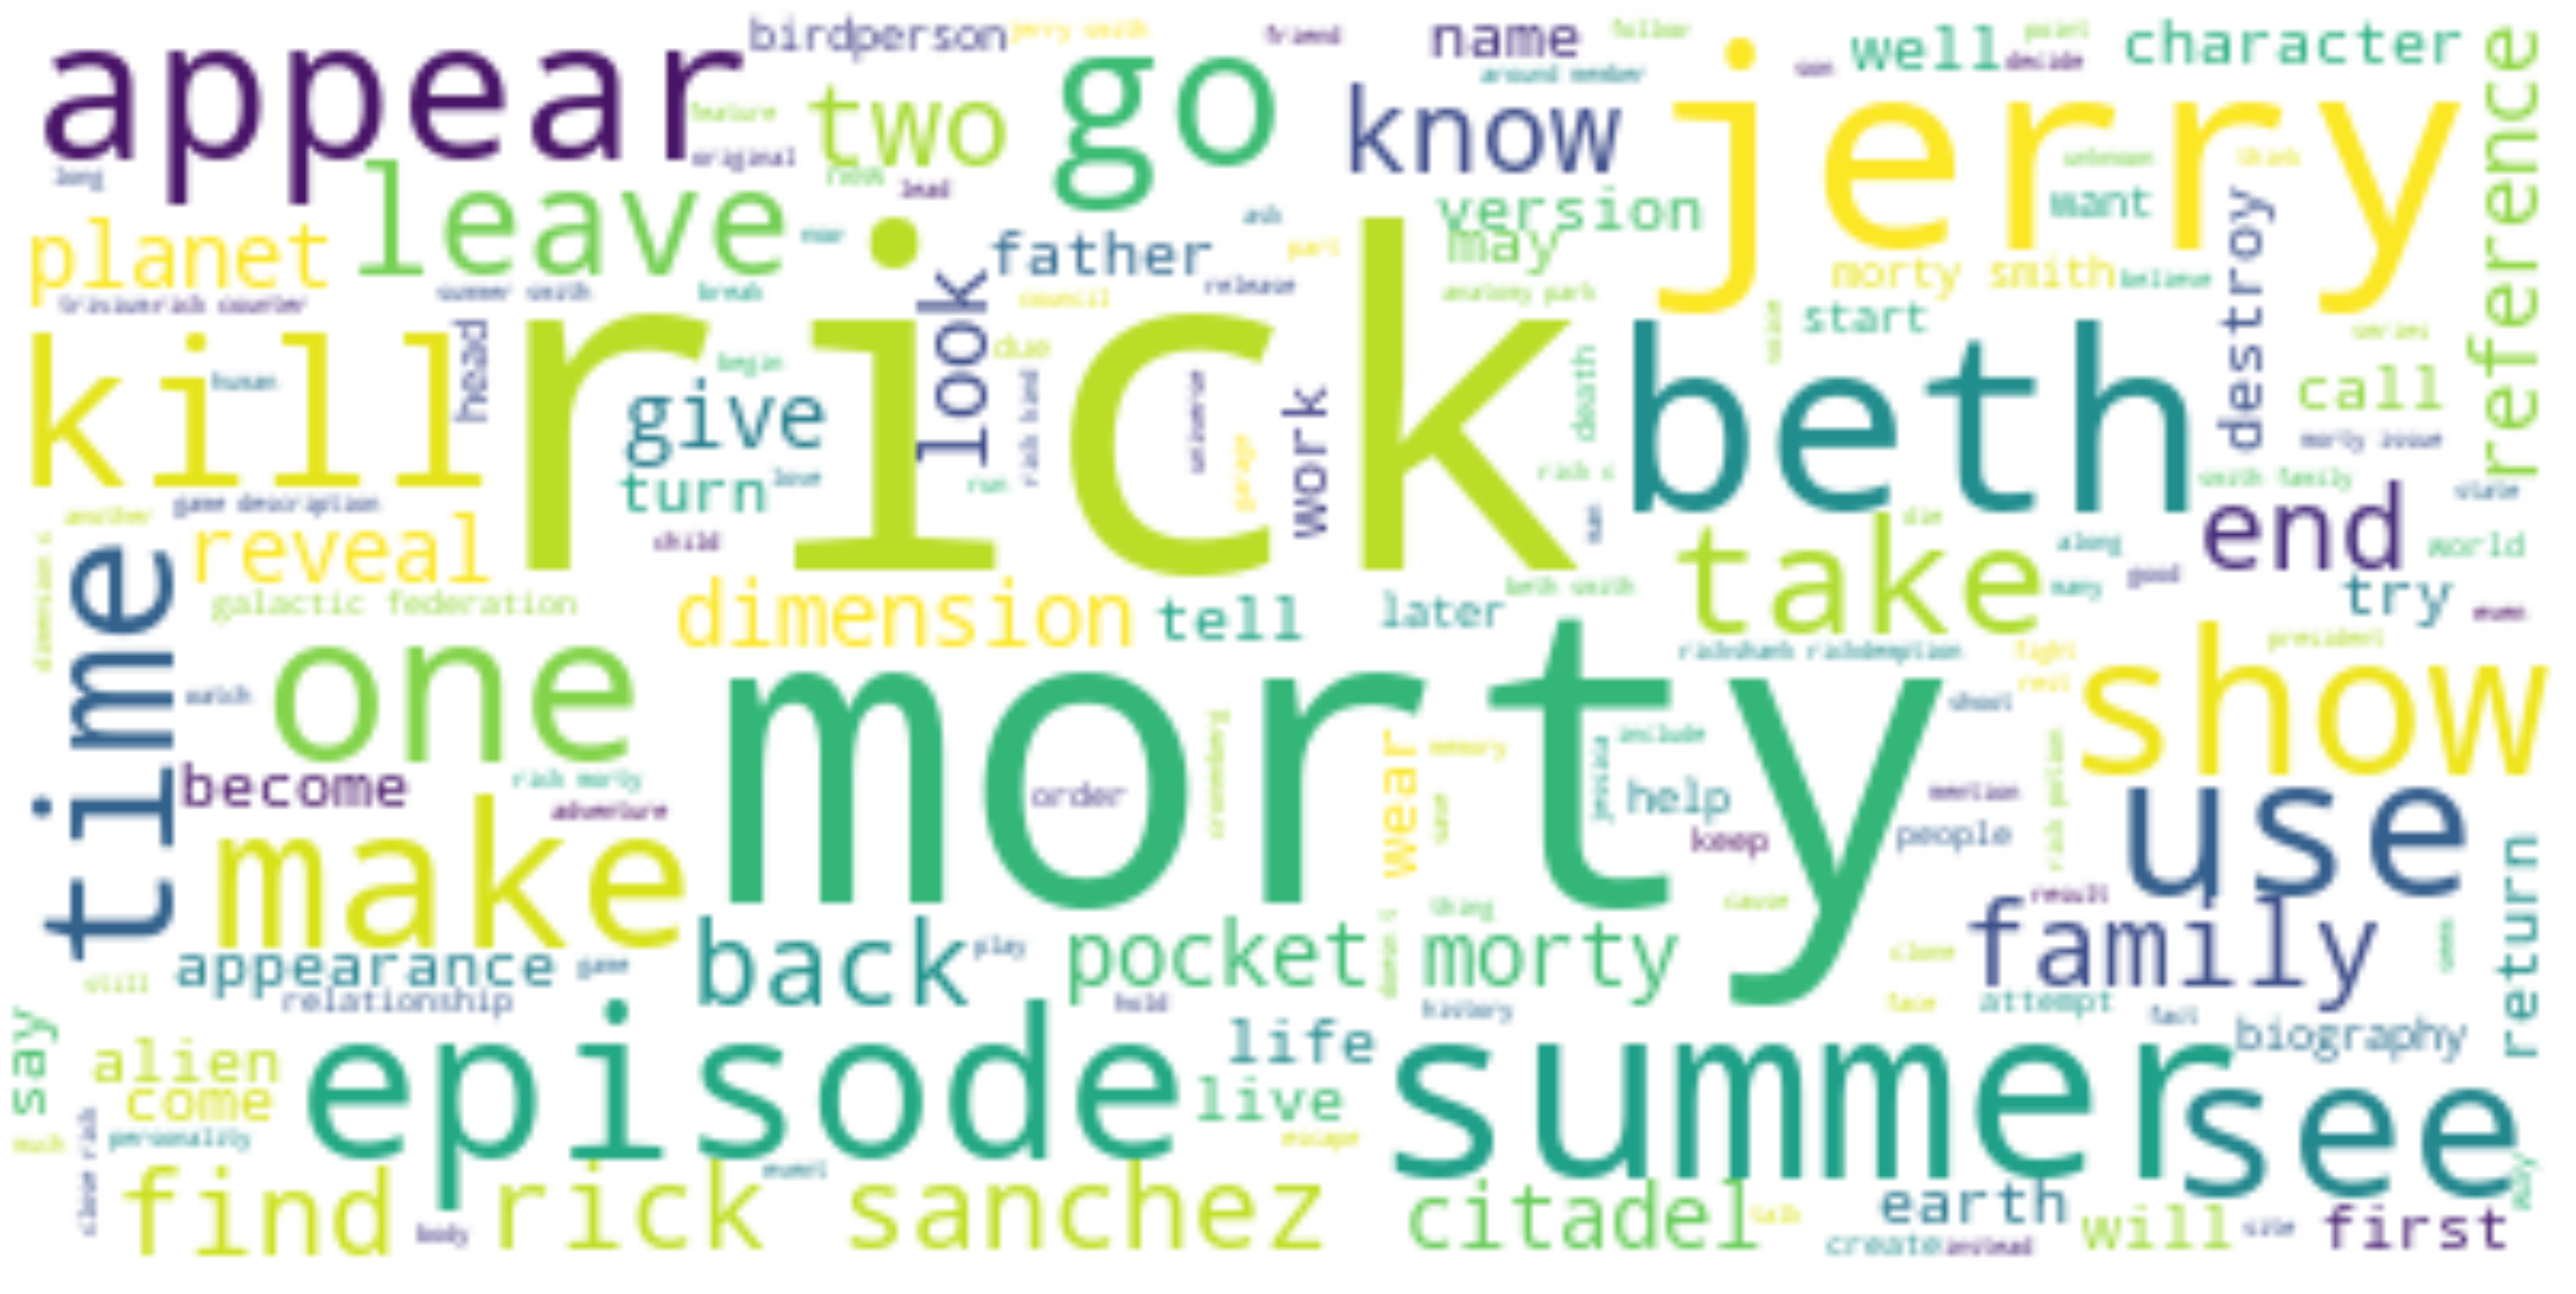

In [68]:
from wordcloud import ImageColorGenerator, STOPWORDS, WordCloud


wordcloud = WordCloud(background_color="white").generate(df_articles.content.str.cat())
plt.figure(figsize=(50,50))
plt.imshow(wordcloud, interpolation = 'bilinear', )
plt.axis('off')
plt.show()


### Length of articles

<AxesSubplot: ylabel='Frequency'>

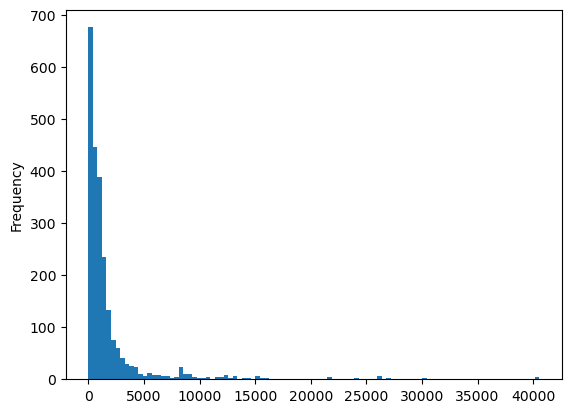

In [85]:
pd.set_option("display.max_colwidth", 50) # default

df_articles.content.str.len().plot.hist(bins=100)

We can see that there most articles has less that `5000` terms.
But there are some extremely long articles containing more than `4000` terms.

### Examining bigrams


<AxesSubplot: >

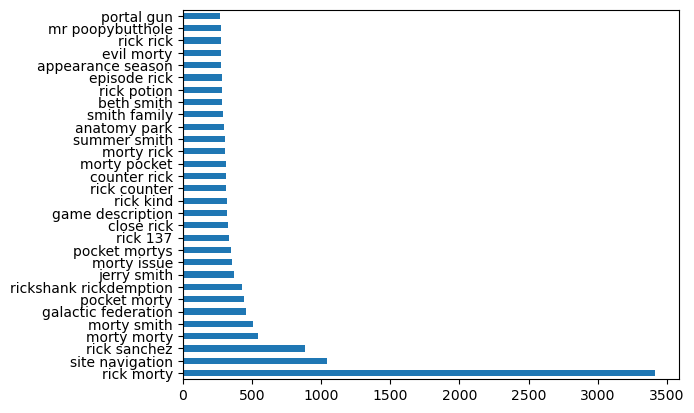

In [110]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', ngram_range=(2,2))

X = vectorizer.fit_transform(df_articles.content)
df = pd.DataFrame(X.toarray(),
    columns = vectorizer.get_feature_names_out())

df.sum(axis=0).sort_values(ascending=False)[:30].plot.barh()

### Examining trigrams

<AxesSubplot: >

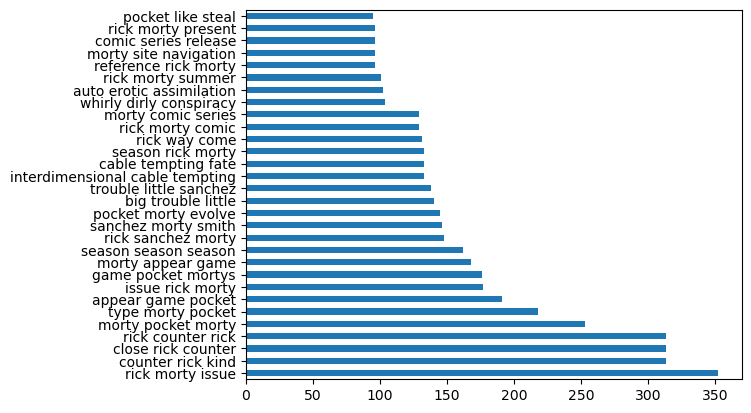

In [111]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(3,3))

X = vectorizer.fit_transform(df_articles.content)
df = pd.DataFrame(X.toarray(),
    columns = vectorizer.get_feature_names_out())

df.sum(axis=0).sort_values(ascending=False)[:30].plot.barh()